# Quantum Computing in 2 Hours

**Notebooks like this one have a lot of functionality, but the main things you need to know are how to run a "cell" and how to edit one. You can just click on a cell to get an editor, and use "shift+return" to run the cell (either code or markup).**

In [ ]:
#@title "Software Installs [Run this cell with Shift+Enter!]"
!pip install qiskit >& /dev/null

In [ ]:
import numpy as np
import qiskit
print(np.__version__)
print(qiskit.__version__)

from qiskit import QuantumCircuit, Aer, execute

1.19.5
0.16.4


We will also use some code and functions [originally written by Dr. C. Moran](https://www.frontiersin.org/articles/10.3389/fphy.2018.00069/full) for qubit visualization.

In [ ]:
#@title "NumPy Qubits and Bloch sphere plotting functions [Run me!]"
zero_qubit=np.matrix('1; 0')
one_qubit=np.matrix('0; 1')
plus_qubit=1/np.sqrt(2)*np.matrix('1; 1')
minus_qubit=1/np.sqrt(2)*np.matrix('1; -1')
clockwisearrow_qubit=1/np.sqrt(2)*np.matrix([[1],[np.complex(0,1)]])    
counterclockwisearrow_qubit=1/np.sqrt(2)*np.matrix([[1],[-np.complex(0,1)]])

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
def get_bloch_coordinates(qubit):
    def get_x_bloch(qubit):
        qubit_x_basis=1./np.sqrt(2)*np.matrix('1 1; 1 -1')*qubit 
        prob_zero_qubit=(qubit_x_basis.item(0)*qubit_x_basis.item(0).conjugate()).real
        prob_one_qubit=(qubit_x_basis.item(1)*qubit_x_basis.item(1).conjugate()).real
        return prob_zero_qubit-prob_one_qubit

    def get_y_bloch(qubit):
        qubit_y_basis=1./np.sqrt(2)*np.matrix('1 1; 1 -1')*np.matrix([[1,0],[0,-np.complex(0,1)]])*qubit
        prob_zero_qubit=(qubit_y_basis.item(0)*qubit_y_basis.item(0).conjugate()).real
        prob_one_qubit=(qubit_y_basis.item(1)*qubit_y_basis.item(1).conjugate()).real
        return prob_zero_qubit-prob_one_qubit

    def get_z_bloch(qubit):
        qubit_z_basis=qubit
        prob_zero_qubit=(qubit_z_basis.item(0)*qubit_z_basis.item(0).conjugate()).real
        prob_one_qubit=(qubit_z_basis.item(1)*qubit_z_basis.item(1).conjugate()).real
        return prob_zero_qubit-prob_one_qubit
    return (get_x_bloch(qubit),get_y_bloch(qubit),get_z_bloch(qubit))

def plot_bloch(qubit,color='b',ax=None):
    if not ax:
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')
        
        # draw sphere
        u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
        x = np.cos(u)*np.sin(v)
        y = np.sin(u)*np.sin(v)
        z = np.cos(v)
        ax.plot_wireframe(x, y, z, color="k",alpha=.1)
        ax.grid(False)

    coordinates=get_bloch_coordinates(qubit)
    ax.quiver([0],[0],[0],[coordinates[0]],[coordinates[1]],[coordinates[2]],length=1,color=color,arrow_length_ratio=0.3)
    ax.set_xlim([-1,1])
    ax.set_ylim([-1,1])
    ax.set_zlim([-1,1])
    ax.set_xlabel('x: |"-"> to |"+">')
    ax.set_ylabel('y: |"↺"> to |"↻">')
    ax.set_zlabel('z: |"1"> to |"0">')
    ax.view_init(azim=20)
    return ax

i_ = np.complex(0, 1)
H = 1. / np.sqrt(2) * np.matrix('1 1; 1 -1') 
X = np.matrix('0 1; 1 0')
Y = np.matrix([[0, -i_], [i_, 0]])
Z = np.matrix([[1, 0], [0, -1]])

def pretty_print_number(amnt):
    the_string = locale.format_string("%12.0f", amnt, grouping=True)
    print("{}".format(the_string))

# other libraries
import locale
import pprint
import scipy.optimize

This is [Google Colaboratory](https://colab.research.google.com) notebook. It gives us a way to run code on a machine sitting in the [Google Cloud](https://cloud.google.com/). And it is free! It is a great platform for sharing code and programming projects. You need a Google account if you want to save a copy of the notebook (to edit and play with), but you should be able to run it without one.

The notebook model for running code is very popular. Notebooks supports markup (using [Markdown](https://daringfireball.net/projects/markdown/)) as well, so they are good for building rich documents with graphics, formatted text, and program execution. The most widely used notebook software is [Project Jupyter](https://jupyter.org/). It is easy to set up on a personal computer if you are so inclined.

The programming language backing our work here is [Python](https://www.python.org/). If you're completely new to Python, the [official "getting started" information](https://wiki.python.org/moin/BeginnersGuide) is great. Don't worry if you've never seen Python code before - it is readable and you'll be able to get a lot out of this notebook even if you don't understand all of the code syntax. 

This notebook was last updated using [NumPy](https://numpy.org/) version 1.19.5 and [Qiskit](https://qiskit.org/) version 0.16.4. It may not function correctly with different software versions.

## Outline

0. Brief aside on entanglement and superposition.
1. "Classical" computation with the _circuit model_.
2. Limitations of the classical computing model.
3. Distinguishing features of _quantum computation_.
4. The quantum circuit model.
5. Qubits and operators, with some math.
6. A quantum computing application ("cryptography") - detecting eavesdroppers on a data line.

## Brief aside - pre-requisites

In order to really understand _quantum computing_ we need to understand something about _quantum mechanics_. We don't need to know quantum mechanics to write quantum programs - we can just adopt some funny rules and move on. But, to actually understand where those rules come from, we need quantum mechanics.

There isn't time to teach quantum mechanics today - but we will briefly review two key concepts: **entanglement** and **superposition**. There is no analog of these effects in classical physics (which is what we call "pre-quantum" physics).

### Entanglement

[Entanglement](https://en.wikipedia.org/wiki/Quantum_entanglement), to put it briefly, is a phenomenon in which two distinct particles become physically related such that actions or measurements on one affect the other.

Classically, if we have two particles, say billiard balls, there is nothing we can do to them such that later measurements of one have anything to do with the other. For example, set them spinning and bang them into each other. Stop one of them as a measurement of how fast it was spinning. Does anything happen to the other? No. Do we know for sure how fast the other one was spinning? No.

If they were quantum particles though, we could bang them together such that they became entangled. Now if we stop one to measure it we affect the other one!

**So entanglement is a mechanism for making two things act like one thing, even when separated physically by large distances.**

### Superposition

[Superposition](https://en.wikipedia.org/wiki/Quantum_superposition) is a phenomenon in which a quantum particle may exist in more than "state". It is not the case that the particle really is in one state or the other and we just don't know. It is in two states (or more!) simultaneously.

This is the phenomenon at the root of the [Schrodinger's cat](https://en.wikipedia.org/wiki/Schr%C3%B6dinger%27s_cat) paradox. We put a cat in a box with a radioactive particle that could decay in one hour and spring a trap that would kill the cat. We leave and come back an hour later. Is the cat dead or alive? The radioactive particle decays through a quantum process. Until we measure the state of the particle, it is actually both "decayed" and "un-decayed" at the same time. So the cat both dead and alive at the same time?

**So superposition is a mechanism by which a thing can exist in more than one state at the same time.**

Note that we snuck in an extra concept here - namely that _measuring_ a quantum state collapses the superposition. We'll say more about quantum measurement below, but the idea is that a quantum object can exist in more than one state at once until it is observed.

<img src="https://www.dropbox.com/s/rq10vdpi9575z62/blog_schrodinger1.jpg?dl=1">

(Quantum mechanically this cat is 50% dead and 50% alive - both at once! Once we _measure_ the state, we find only one or the other. However, if we manipulate the state before measurement, say, to do a computation, the superposition impacts the answer.)

## Computation is performed by physical systems

Let's start with the big picture! What _is_ computation?

<img src="https://www.dropbox.com/s/lo7ag95e2gw4fqi/matrix-code-rain1.jpg?dl=1">

**Computation is _simulation_ combined with _interpretation_ - it is manipulating a physical system in search of a result where the system is an abstract representation of a real problem.**

Think about an abacus - it is a physical system, and if you follow some rules for moving the beads around, you can interpret the new position of the beads as reflecting a arithmetic operation. The abacus doesn't know it added numbers, we just know to interpret the states as such.

<img src="https://media.giphy.com/media/3tEFVAbfzzcwo/giphy.gif">

But an abacus is slow. Well - some people are [really fast](https://www.youtube.com/watch?v=GQtqlB-jXO0) with them. But, today we use electronic devices. To add two numbers on an electronic device we develop an _algorithm_, which tells us how to relate an arithmetic operation to the manipulation of binary states and then we simulate that operation by running currents and measuring voltages.

Let's look at some basic concepts in classical computing using the _circuit model_ before we think about quantum computing to set the stage.

Also - note that there is some deep philosophy here! You may be wondering "why are we talking about quantum computing in a physics class?" - but if computation is simulation of algorithms by physical systems... **what is our physical universe "computing?" It is _absolutely_ computing _SOMETHING_.** 

There is a school of thought in physics that at the bottom of it all in our search for everything we will find only [information theory](https://en.wikipedia.org/wiki/Information_theory) - and it will necessarily be _quantum_ information theory!

## Classical circuit model

### Start with: Addition with binary numbers

<img src="https://www.dropbox.com/s/pwk6sw7ex1rspq0/10kindsofpeople.jpg?dl=1">

To add two numbers with a computer (something like a smartphone or a laptop), we first represent them in [_binary_](https://en.wikipedia.org/wiki/Binary_number). Binary numbers are base-2. We're used to base-10, but base-2 (and base-16) are very useful in computer science. A base 10 number looks like this: 

```
765 = 7 x 10^2 + 6 x 10^1 + 5 * 10^0
```

The rightmost digit is 5 times ten to the power _zero_. The next digit moving to the left is 6 times ten to the power of one. Finally, at the leftmost edge we have 7 times ten to the power of two. Binary numbers are essentially the same, but instead of ten to some power per place, we use two to some power:

```
0b101 = 1 x 2^2 + 0 x 2^1 + 1 x 2^0
```

Here, the rightmost digit is 1 times two to the power zero. Moving left we have 0 times two to the power of one. Finally, on the leftmost edge we have 1 times two to the power of two. In base-10 we would write this number as "5". In base-10 digits range between 0 and 9 and in base-2 they range between 0 and 1.

Binary is useful for computation with physical systems because we can represent binary numbers with two-level systems, and two-level systems are simple. There are many _electronic_ two-level systems that we can manipulate very quickly.

So, we set up a set of registers with "positive" (1) and "negative" (0) values (imagine little magnets or different voltage levels, etc.). Then we set up a third register to hold the result (and one for the "carry") and flip the positive and negative values in the results register based on a scan over the first and second registers (and the carry!), combined with some simple rules, and we can add numbers:

<img src="https://www.dropbox.com/s/wgfi9lpl4qqbxv3/add_two_binary_numbers_rules.png?dl=1" height="90">

<img src="https://www.dropbox.com/s/dlkgen3tuk4hecv/add_three_binary_numbers_rules.png?dl=1" height="90">

Here we add 6 and 7:

<img src="https://www.dropbox.com/s/1rtvegu05pxfrab/binary_addition.png?dl=1" height="150">

For more, see this [web app](https://chortle.ccsu.edu/AssemblyTutorial/zAppendixE/binaryAdd.html).

In [ ]:
0b110 + 0b111

13

In [ ]:
bin(13)

'0b1101'

So really, there are 0b10 kinds of people in the world...

Now, let's build some _circuits_...

### Logic gates

It is reasonable to ask: "okay, once you have these rules for binary addition, how do you _implement_ them in hardware?" Where is the physical system simulating our algorithm?

This civilization has figured out how to use [transistors to implement _logic gates_](https://en.wikipedia.org/wiki/Transistor–transistor_logic). We represent theses gates visually as circuits - lines carry data (classical binary digits - 0's and 1's) and the gates themselves are symbols with line inputs and outputs. We use _truth tables_ to show the action of the gate on the data in the line.

<img src="https://www.dropbox.com/s/2icjygcysqrkqeo/LogicCircuitsWithTables1.png?dl=1" alt="Logic circuits">

Some composite gates are so popular they are often built as primitives:

<img src="https://www.dropbox.com/s/dkas7n803ypiz3e/LogicCircuitsWithTables2.png?dl=1" alt="Logic circuits">

You can see how you would implement a table like this one with logic gates:

<img src="https://www.dropbox.com/s/wgfi9lpl4qqbxv3/add_two_binary_numbers_rules.png?dl=1" height="90">

You need two inputs and two outputs. This function is called a _Half Adder_:

<img src="https://www.dropbox.com/s/3a93go55dqayy7u/HalfAdderWithTable.png?dl=1" alt="Half Adder">

We may combine Half Adders and an OR gate to build a _Full Adder_:

<img src="https://www.dropbox.com/s/bptqkr6p4j0bg4d/FullAdderWithTable.png?dl=1" alt="Full Adder">

We may cascade Full Adders to add even larger numbers. So, for example, for two 3-bit numbers, we have:

<img src="https://www.dropbox.com/s/fg4tu81iwgv1y7h/CascadedAdder.png?dl=1" alt="Cascaded Adders">

**Exercise:** Verify this circuit performs addition correctly.

**Exercise:** Can you work out a circuit for binary multiplication?

This is looking at software at a pretty low level. It isn't quite the bottom since we aren't getting into how you actually implement transistor logic gates, but this is close to the bottom of the "software stack." These logic gates are built into the _hardware_ directly. When you hear a chip has a billion transistors, that is sort of like saying it has a layout with about that many of these gates and combinations. If you run electrical current through them, they mechanically churn out "answers."

From there, you layer on different types of abstractions. You can build circuits to do things besides add binary numbers, and then you can bundle collections of circuits to start to do more complex tasks. Some circuits you use so often that you "hard code" them right into the silicon. Others you might make more flexible. People have been working on optimizing these choices for _decades_, and working in parallel to make transistor logic gates smaller, faster, and robust to errors. Amazingly, it turns out you can make the _bottom_ layer very simple - you can do everything with `NAND` gates!

At the end you have the power to write expressive programs that can, in principle, compute anything!

## Limits to "classical" computing 

Wait, can we really compute _everything_ we might want to under this paradigm?

Well - in some senses we _can_, but there are practical limits imposed by required resources: time, energy, etc. Remember, we have to _build_ a physical system that can simulate a calculation by analogy. We have to run current through transistors and flip bits. We can only make that system run so fast.

In other words, we can write down an algorithm to solve a problem, but if it requires the lifetime of the universe to simulate on some physical device and provide an answer, we haven't actually solved the problem in the way we care about! For example, we can tell someone algorithmically how to build a molecule that might cure cancer, but we can never tell them what that molecule actually is!

Suppose we want perform a simulation of a molecule to compute chemical properties (e.g. some protein binding affinity). Electrons are two-state _quantum_ systems! This means that in order to write down the physical description of a set of electrons (which features _superposition_ and _entanglement_), we need to do a lot of book-keeping. In fact, the set of numbers we need to write down the state of the system scales like $2^N$, where $N$ is the number of electrons.

Imagine we have 50 electrons in our molecule (that matter for its chemistry). If one number were one byte (8) bits of precision, 50 electrons require a lot of Gigabytes of memory:

In [ ]:
2**50 / 8 / 1e9

140737.488355328

This is roughly the scale of a world-class supercomputer, so humans can do this. Suppose you come up with a new idea for a molecule with 100 important electrons. If $2^{50} \simeq 1$ world-class supercomputer, how much is $2^{100}$?

In [ ]:
print("{:1.5g}".format(2**100 / 2**50))

1.1259e+15


That is a million billion supercomputers! Currently humans have maybe three machines of this class... with no way of making them work _together_ efficiently.

What to do?

The computational devices we're used to (transistor based implementations of logic gates) must "brute force" the calculation of superposition and entanglement. These costs scale **exponentially** with the size of the system. We need them to run much faster, and we need many more of them... Great, [Moore's Law](https://en.wikipedia.org/wiki/Moore%27s_law) to the rescue, right? After all, computing "power" has been roughly doubling every two years for a long time, right? So, exponential power is coming to bear... Can we just wait?

<img src="https://media.giphy.com/media/SVgKToBLI6S6DUye1Y/giphy.gif">

We face several key limitations in the search for faster, better, and cheaper computation. 

Chips with transistors smaller than 7 nm have proven to be extremely costly to fabricate and it is unclear whether anything smaller than 3 nm is viable. This would signal the actual end of [Moore's Law](https://en.wikipedia.org/wiki/Moore%27s_law). We have even more serious problems with [Dennard Scaling](https://en.wikipedia.org/wiki/Dennard_scaling). There are [5 nm chips](https://www.anandtech.com/show/16088/apple-announces-5nm-a14-soc-meagre-upgrades-or-less-power-hungry) out there now, but we can't _turn on_ the whole chip or it will melt.

Parallelizing our algorithms helps, but that approach is bounded because ultimately we simply become dominated by the pieces of the algorithm that we can't parallelize.

<img src="https://www.dropbox.com/s/02a9tpkbcpm46t4/limits_to_classical_comp_m_alam_rigetti.png?dl=1">

Figure courtesy of M. Sohaib Alam, [Rigetti Computing](https://www.rigetti.com/).

This seems pretty hopeless - we need computing resources on scales that are ludicrously beyond the scale of this civilization. We need to convert whole galaxies into computers somehow. But we'd really like to solve these problems! Cancer sucks!

Maybe the problem is that we're trying to use the wrong hardware (two-level digital logic in silion) to simulate this algoritm. Maybe we should build a different computation device? For example, if we wanted to simulate molecules to look for new drugs to cure cancer, we could build some system out of molecules themselves that would be more naturally suited to the problem.

Good idea! We call this "chemistry", and it is great. The problem is these "simulators" are so complex that they are impossible to program. We can set up experiments to answer a specific question, but we can't automate them or put them into other algorithms. And we need the stuff too, the atoms and molecules. What if they are rare, hard to get, or very expensive to synthesize?

What we want is an extension to our current paradigm that gives us more simulation power or one that lets us get around some of the physical limitations we're dealing with.

## Quantum computing

Let's talk about an approach to computation that deals with both of these problems. We've mentioned computing properties of molecules already - why is this hard? It turns out the answer lies in the fact that molecules are [_quantum_](https://en.wikipedia.org/wiki/Quantum_mechanics) systems. Superposition means we need a _huge_ set of digital numbers to describe them, which is why digital simulators struggle with them. The physics is just wrong for our simulator. For example, would you use an abacus to simulate a chemistry problem?

Do we have a computing device that can simulate the physics of a quantum system? Our best candidate is a _quantum computer_.

Quantum computing is the manipulation of _quantum states_ to perform a computation. The major difference with the classical model is we now use quantum bits, or **qubits**. Qubits can access _superpositions_ of states (as opposed to only 0 and 1) and may be _entangled_. Entanglement and superposition mean the state space for a set of $n$ qubits is $2^n$ - it grows exponentially with the number of qubits.

By the way electrons can be thought of as natural qubits (modulo some issues with Fermi statistics, but don't worry about that right now). Quantum computers map _beautifully_ to the sort of problem discussed above.

<img src="https://www.dropbox.com/s/m8tcwnwil13ecxa/qubit_scaling_m_alam_rigetti.png?dl=1">

Figure courtesy of M. Sohaib Alam, [Rigetti Computing](https://www.rigetti.com/).

The physical manifestation of our machine is very different than what we're used to. For example, our "computer" might involve a set of spins (in a "register") that we manipulate (e.g. trapped ions with laser pulses), moving from one quantum state to another.

<img src="https://www.dropbox.com/s/pqemqzoxhy1z09m/registerofqubits.png?dl=1">

Here are some photos of real quantum computing devices:

<img src="https://www.dropbox.com/s/356mwsff5jo6s3m/pictures-of-quantum-hardware.png?dl=1">

From left to right: Google's superconducting transmon chip ([Sycamore](https://ai.googleblog.com/2019/10/quantum-supremacy-using-programmable.html)), Fermilab's [superconducting radio frequency cavity](https://sqms.fnal.gov/research/), Honeywell's [ion trap](https://www.honeywell.com/en-us/company/quantum), Xanadu's [photonic chip](https://www.xanadu.ai/hardware).

Generally we need to cool quantum devices down to very close to absolute zero (although not always - e.g., ion traps can operate at room temperature). This requires the use of [dilution refrigerators](https://en.wikipedia.org/wiki/Dilution_refrigerator), which look cool and show up in press photos all the time.

Here are a couple - on the left Fermilab scientists Dan Bowring and Rakshya Khatiwada are working on a fridge that will use qubits as _detectors_, and on the right we have a "promotional" photo from [Bluefors](https://bluefors.com/):

<img src="https://www.dropbox.com/s/ewq1q25avfzrvhn/dil-fridges.png?dl=1">

### Quantum supremacy?

Exponential growth in the available state space is what allows for the concept of [quantum supremacy](https://en.wikipedia.org/wiki/Quantum_supremacy). But does it really work? Can we really compute something beyond the reach of a classical computer?

In short - yes. In October of 2019, [Google announced](https://ai.googleblog.com/2019/10/quantum-supremacy-using-programmable.html) that they built and operated a quantum computer for a "supremacy" demonstration. It was the the sort of rare science news that actually broke through to mainstream media publications.

You can read more about quantum supremacy [here](https://www.scottaaronson.com/blog/?p=4372) and some dissent about whether this milestone was truly achieved [here](https://www.ibm.com/blogs/research/2019/10/on-quantum-supremacy/). My favorite take on this is from [Scott Aaronson](https://www.scottaaronson.com/blog/?p=4317).

The basic idea is Google used a quantum computer to sample from a very difficult to calculate probability distribution and proved that they were actually correctly sampling from the distribution 0.2% of the time (the rest of the time the computer was producing gibberish).

Is this useful? Or practical? Not in and of itself, but it demonstrated that it was possible to build a quantum computer capable of performing calculations that are prohibitively expensive for a classical computer.

### What are quantum computers pracitcally good for?

It is difficult to say what the real "killer app" is at this point. We are still in very early days in quantum computing. Microsoft has put together a [slick video series](https://www.youtube.com/playlist?list=PLFPUGjQjckXFsOEBvvaDeIk5GxctP0ZhX) you can watch sometime for one (very corporate, very buzz-word laden) take on the question.

One thing we can be sure they will be good for though is simulating quantum systems. There are _many_ such systems we care about:

* Chemicals (e.g. drugs),
* Materials,
* Black holes (?),
* Nuclear matter,

and so on. 

Why would we need a quantum computer to simulate these systems?

Fundamentally quantum systems must be described using quantum mechanics, which means we must allow for superposition and entanglement, and we must be able to compute with these objects.

## Qubits

Unlike classical bits, which may only have the value of 0 or 1, qubits can be _superpositions_ of these states. We write down a qubit's "value" using a **state vector** to denote how much of each value is superposed into the qubit.

So, a classical bit's _state_ is written like this:

$$
v = 0~\text{or}~1
$$

and a qubit's _state vector_ is written lke this:

$$
|\psi\rangle = \begin{pmatrix} \alpha \\ \beta \end{pmatrix} = \alpha \times \begin{pmatrix} 1 \\ 0 \end{pmatrix} + \beta \times \begin{pmatrix} 0 \\ 1 \end{pmatrix} \equiv \alpha |0\rangle + \beta |1\rangle
$$

where $|0\rangle$ and $|1\rangle$ are _basis states_ in a basis we call the computational basis. Think of them like "heads" and "tails" on a coin.

We'll call $|0\rangle$ the "zero qubit" and we'll call $|1\rangle$ the "one qubit" and let the basis be implicit. $\alpha$ and $\beta$ are complex numbers obeying the _normalization_ condition

$$
\alpha^2 + \beta^2 = 1
$$

### The Bloch Sphere

We often use a construct called the [Bloch Sphere](https://en.wikipedia.org/wiki/Bloch_sphere) to represent a (single) qubit visually. The Bloch sphere gives us a way to visualize how qubits with different $\alpha$ and $\beta$ values "look" by mapping those points onto a two-dimensional surface (best visualized as a point on a sphere):

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


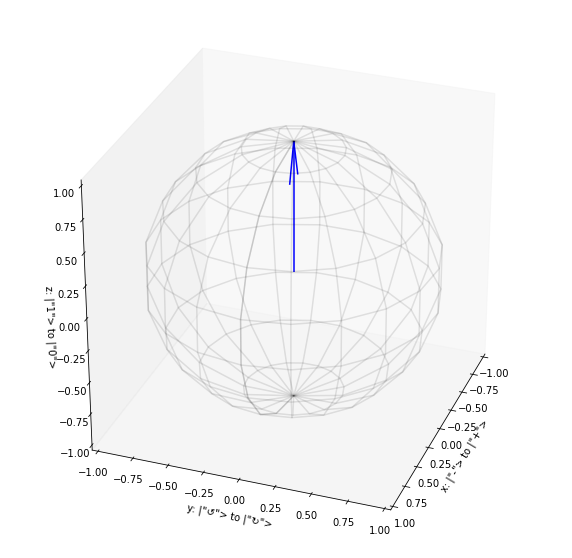

In [ ]:
plot_bloch(zero_qubit)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


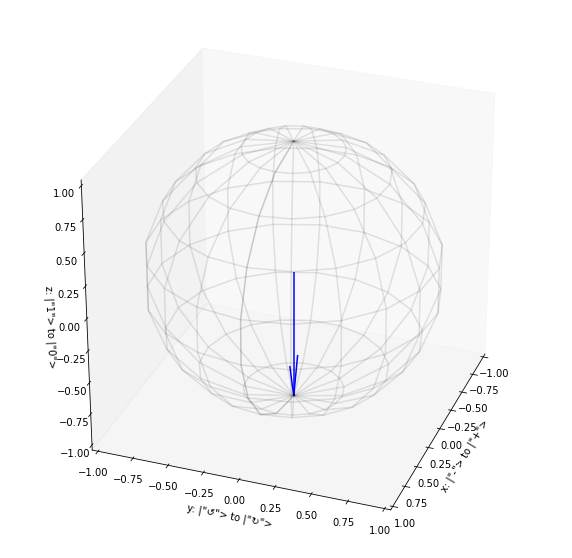

In [ ]:
plot_bloch(one_qubit)

Suppose we choose an arbitrary $\alpha$ and $\beta$ pair? Recall the restriction that $\alpha^2 + \beta^2$ must equal 1.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


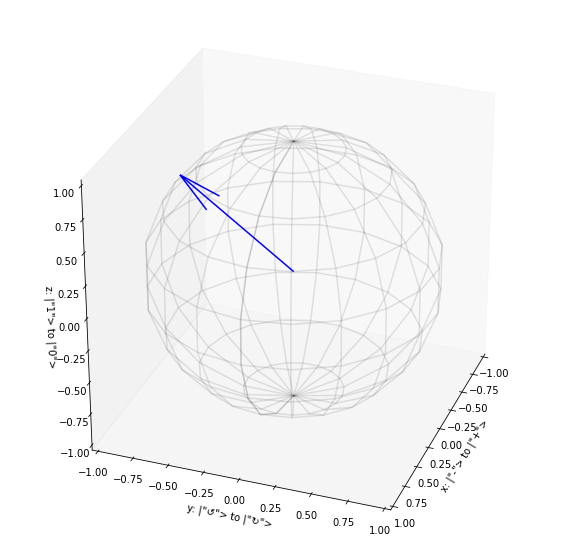

In [ ]:
eighty_twenty_qubit = np.sqrt(0.8)*zero_qubit - i_ * np.sqrt(0.2)*one_qubit
plot_bloch(eighty_twenty_qubit)

**Exercise:** Play with this code and draw some new qubits. One important piece of information:

$$
\alpha^2 + \beta^2 = 1
$$

really means

$$
\alpha^* \alpha + \beta^* \beta = 1
$$

where $\alpha^*$ is the _complex conjugate_ of $\alpha$. Here, that just means $i \to -i$, so 

$$
(2 + 3i)^* = 2 - 3i
$$

etc.

### Measurement

Measurement is a two-step process - first we must choose a _basis_, and second we choose what we are measuring. The measurement itself will always give us a state in that basis.

An example of a basis is the "0/1" basis we've been implicitly using so far. When we make a measurement, we "collapse the wave function". This means that if our original state was in a superposition, it no longer is. Measured states cease to be in superposition and they remain in the state they collapsed to no matter how many addition measurements we perform. The _probability_ a measurement is equal to the square of the amplitude of its superpositions.

So, if our initial state is
$$
\psi = \sqrt{0.8} |0\rangle + \sqrt{0.2} |1\rangle
$$
we have an 80% chance of measureing $|0\rangle$ and a 20% chance of measuring $|1\rangle$ and every subsequent measurement will give the same answer - after the measurement the superposition is destroyed and we no longer have a probabilistic state.

Wait, who chose the direction of "0"? Once that is fixed, the direction of "1" is fixed (on the Bloch sphere), but isn't the initial choice arbitrary?

Well, yes, it is. Perhaps there is a natural asymmetry in our problem space (defined by a physical magnet, for example), but perhaps not. Often the basis is defined by our measurement instrument. When we talk about _bases_ we are referring to other valid choices for that initial direction. We can always transform from one basis to another. (When we do have a natural asymmetry this can have important consequences for measurement.)

Anyway, quantum mechanics is weird! We don't have time to go into the quantization of spin (spin-1/2 particles are good examples of two-level quantum systems), but you can read about it [on your own time](https://en.wikipedia.org/wiki/Stern%E2%80%93Gerlach_experiment)...

The bottom line is that quantum computers make _probabilistic_ calculations. You can't run a quantum computer once to know the answer to a problem - you have to run it many times and converge on the answer.


## No cloning!

<img src="https://media.giphy.com/media/l1Kst3WE3rg2WRHxu/giphy.gif">

(We don't mean that kind of clone...)

A very important property of qubits is - we can't copy them! (In general.) This is a consquence of something called the [no cloning theorem](https://en.wikipedia.org/wiki/No-cloning_theorem).

Of course, if you know your qubit is in one of the basis states (after a measurement for example), you can easily "copy" it by putting another qubit into that state, but you can't copy an arbitrary qubit. You can read about the no-cloning theorem, but a simple, practical way to understand it is this: Remember our 80-20 qubit above? The amplitude of one of our basis states was $\sqrt{0.2}$. What is that number?

In [ ]:
np.sqrt(0.2)

0.4472135954999579

Of course, that is wrong. We can only _approximate_ that number. It is "irrational." We need an inifinite number of digits to represent it. If we wanted to copy a qubit, we need to look at the amplitudes. But the only way we can do that is by making a measurement. Making a measurement destroys the superposition. So actually we need a _lot_ of qubits exactly like the one we want to copy. We will measure all of them and get better and better estimates of the amplitudes as we measure more and more of them.

But, even if we could somehow get them (and how would we?) - we would need to measure an _infinite_ number of them to get the amplitudes exactly right. You can't do it!

## Quantum circuits - lines and gates

Quantum circuits will be composed of data lines and gates (operators), like our classical circuits, but there are some differences. 

We can't split lines (implict copying) in a quantum circuit. 

For profound reasons (conservation of a sensible universe, basically), quantum 
"operators" are [unitary](https://en.wikipedia.org/wiki/Unitary_operator). This means quantum circuits are _reversible_, which in turn means we can't have, for example, two lines go into a gate and only one line coming out if it isn't clear how to run the circuit "in reverse".

Here is a quantum circuit:

<img src="https://www.dropbox.com/s/s31nu2w0psdgqxc/epr-circuit.png?dl=1" height="350">

We'll build this circuit in code later and explain the symbols. The `H` and the cross-bar both represent _quantum gates_. The `H` is acting on one qubit while the cross-bar is acting on two. This circuit is actually creating a _Bell pair_. We'll say more about what that means in a bit.

### Gates are linear operators

Linear algebra (algebra with systems of linear equations) is the foundation of quantum computing. (It is the foundation of a _lot_ of things. It is worth learning about!)

Like classical circuits we operate on quantum circuits with ``gates.'' In quantum computing these gates mathematically take the form of _matrices_. 
Acting with a gate is equivalent to multiplying our state vector with a matrix. 

For single qubits, these gates are $2 \times 2$ _Unitary matrices_. We won't get into the technical details of unitary matrices, but they obey special conditions that mean they are _norm preserving_. 

First, we need to know how to take the _dot product_ of two vectors:

$$\begin{split}
A =& \begin{pmatrix} a_1 \\ a_2 \end{pmatrix};~ B = \begin{pmatrix} b_1 \\ b_2 \end{pmatrix} \\
A \cdot B =&~ a_1 \times b_1 + a_2 \times b_2
\end{split}$$

The dot product is used to define the _norm_, or length, of a vector:

$$\rightarrow |A| = \sqrt{A \cdot A} = \sqrt{a_{1}^2 + a_{2}^2}$$

Next, we need to understand matrix multiplication. Essentially, we dot each column vector of the second matrix (or vector) with each row of the first matrix (imagine picking the column up and "dropping it" on each row). We will only worry about 2x2 matrices and 2x1 vectors here, e.g.

$$
\begin{pmatrix} a_{11} & a_{12} \\ a_{21} & a_{22} \end{pmatrix} \begin{pmatrix} b_{1} \\ b_{2} \end{pmatrix} = \begin{pmatrix} a_{11} b_1 + a_{12} b_2 \\ a_{21} b_1 + a_{22} b_2 \end{pmatrix}
$$

Note that the output shape is 2x1. In general, if we multiply a $MxN$ matrix by an $NxP$ matrix, the output is $MxP$. So, $(2x2)(2x1) \rightarrow (2x1)$. This has all sorts of consequences (we can't multiply matrices of arbitrary shape and the order of multiplication matters, for example).

Can you think of a way states might operate on gates?

**Exercise:** Multiply

$$
\begin{pmatrix} 3 & 2 \\ 4 & -1 \end{pmatrix} \begin{pmatrix} 3 \\ 5 \end{pmatrix} 
$$

## Multiple qubits

We describe multiple bits with state vectors as well.  An example multi-qubit state is:

$$
x = |01101\rangle
$$

Superpositon means the mathematical space these vectors span grows _exponentially_ in the number of qubits. Specifically, quantum state space grows like $2^n$, where $n$ is the number of qubits. We describe a two-bit classical system with one number - it is definitely "00" or "01", etc.

But a quantum system may have a non-zero _amplitude_ in all of the possible states, so for two qubits:

$$
\psi = a|00\rangle + b|01\rangle + c|10\rangle + d|11\rangle
$$

This requires keeping track of four (complex!) numbers. For a two-qubit system, this is no problem, but, for example, a molecule in a chemistry problem might require hundreds of qubits to describe. So...

In [ ]:
pretty_print_number(2**200)

1606938044258990275541962092341162602522202993782792835301376


Of course, there is still a normalization condition on these terms. For example:

$$
\psi = \frac{1}{\sqrt{2}} \left( |001\rangle + |110\rangle \right)
$$

The sum of the squares of the coefficients is 1. This is _always_ the case for a valid quantum state.

Note that here, we have _one state_ that is a combination of values. Based on this _wavefunction_, we cannot say the left-most bit of the register is definitively a 0 or a 1. It is a combination. You might think - well, it is one or the other but we just don't know. This would imply the existence of _hidden variables_ in quantum mechanics. It is beyond the scope of this lecture to handle hidden variables, but there are definitive physical experiments you may conduct that show there are no hidden variables. A quantum state really can be a combination of states.

### Tensor products

How do we write the state vector for multi-qubit states? We need to take the _tensor product_ of the qubits, e.g. $|\alpha\rangle \otimes |\beta\rangle$. _This is not the same as regular multiplication. It has different rules!_ In particular, we need a multiplication operation that takes two two-element vectors and makes a four-element vector. Three qubits should combine to make an eight-element vector.

The clearest way to show how the tensor product works is with an example:

$$
\begin{pmatrix} a \\ b \end{pmatrix} \otimes \begin{pmatrix} c \\ d \end{pmatrix} =  
\begin{pmatrix} a \begin{pmatrix} c \\ d \end{pmatrix} \\ b \begin{pmatrix}  c \\ d \end{pmatrix} \end{pmatrix} = 
\begin{pmatrix} ac \\ ad \\ bc \\ bd \end{pmatrix}
$$

So, 

$$
|0\rangle |0\rangle = 
\begin{pmatrix} 1 \\ 0 \end{pmatrix} \otimes \begin{pmatrix} 1 \\ 0 \end{pmatrix} =  
\begin{pmatrix} 1 \begin{pmatrix} 1 \\ 0 \end{pmatrix} \\ 0 \begin{pmatrix}  1 \\ 0 \end{pmatrix} \end{pmatrix} = 
\begin{pmatrix} 1 \\ 0 \\ 0 \\ 0 \end{pmatrix} =
|00\rangle
$$

This generalizes to higher dimensions in the "obvious" way, e.g.

$$
\begin{pmatrix} a_1 & b_1 \\ c_1 & d_1 \end{pmatrix} \otimes \begin{pmatrix} a_2 & b_2 \\ c_2 & d_2 \end{pmatrix} =  
\begin{pmatrix} a_1 \begin{pmatrix} a_2 & b_2 \\ c_2 & d_2 \end{pmatrix} & b_1 \begin{pmatrix} a_2 & b_2 \\ c_2 & d_2 \end{pmatrix} \\ c_1 \begin{pmatrix} a_2 & b_2 \\ c_2 & d_2 \end{pmatrix} & d_2 \begin{pmatrix} a_2 & b_2 \\ c_2 & d_2 \end{pmatrix} \end{pmatrix} = 
\begin{pmatrix}
a_1 a_2 & a_1 b_2 & b_1 a_2 & b_1 b_2 \\
a_1 c_2 & a_1 d_2 & b_1 c_2 & b_1 d_2 \\
c_1 a_2 & c_1 b_2 & d_1 a_2 & d_1 b_2 \\
c_1 c_2 & c_1 d_2 & d_1 c_2 & d_1 d_2 \\
\end{pmatrix}
$$

**Exercise:** work out $|0\rangle \otimes |1\rangle$ and $|1\rangle \otimes |1\rangle$

<img src="https://media.giphy.com/media/BmmfETghGOPrW/giphy.gif">

## Quantum Gates

For classical circuits we had gates that we represented with truth tables. For quantum gates, we will use _matrices_.

One example of a valid quantum gate is the _Not_ gate, also called the _X_ gate:

$$
X = \begin{pmatrix} 0 & 1 \\ 1 & 0 \end{pmatrix}
$$

Note that this is a _matrix_. Gate operations are formally equivalent to matrix multiplicatoin. Multiple gate operations together are equivalent to multiplying the matrices together.

If we write it out, we see the Not gate flips one computational basis state to the other:

$$
X |0\rangle = \begin{pmatrix} 0 & 1 \\ 1 & 0 \end{pmatrix} \begin{pmatrix} 1 \\ 0 \end{pmatrix} = \begin{pmatrix} 0 \\ 1 \end{pmatrix} = |1\rangle
$$

Note that this imples $XX = I$. Two applications of $X$ bring us back to the identity.

$$
\begin{pmatrix} 0 & 1 \\ 1 & 0 \end{pmatrix} \begin{pmatrix} 0 & 1 \\ 1 & 0 \end{pmatrix} = \begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix}
$$

With what we've seen so far and a result like this, you should be able to work out how to multiply a pair of 2x2 matrices. (Or $NxN$ for that matter, but in practice, once we go over 3x3, we almost always use a computer.)

Another important operator is the _Hadamard_ gate. It rotates computational basis state vectors into superpositions:

$$
H = \frac{1}{\sqrt{2}} \begin{pmatrix} 1 & 1 \\ 1 & -1 \end{pmatrix}
$$

$$
H \psi = \frac{1}{\sqrt{2}} \begin{pmatrix} 1 & 1 \\ 1 & -1 \end{pmatrix} \times \begin{pmatrix} 1 \\ 0 \end{pmatrix} = \frac{1}{\sqrt{2}} \begin{pmatrix} 1 \\ 1 \end{pmatrix}
$$

$$
\begin{split}
H |0\rangle =&~ \frac{1}{\sqrt{2}} \left(|0\rangle + |1\rangle \right) \equiv |+\rangle  \\
H |1\rangle =&~ \frac{1}{\sqrt{2}} \left(|0\rangle - |1\rangle \right) \equiv |-\rangle  \\
\end{split}
$$

Note that like $X$, $H$ is also its own inverse, such that $HH = I$.

**Exercise:** Work out $HH$ to prove $HH = I$.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


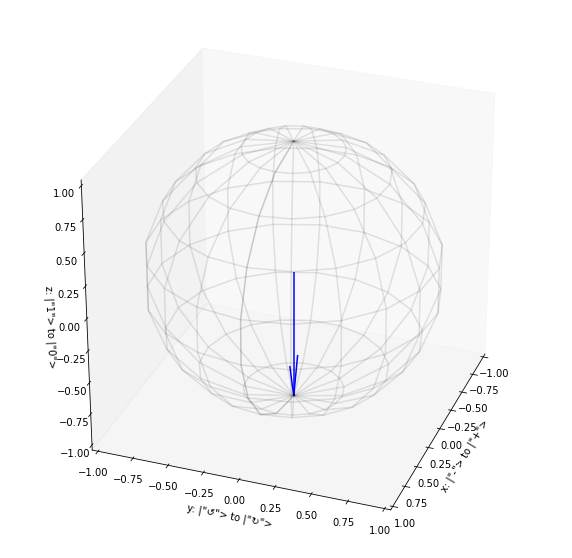

In [ ]:
plot_bloch(X * zero_qubit)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


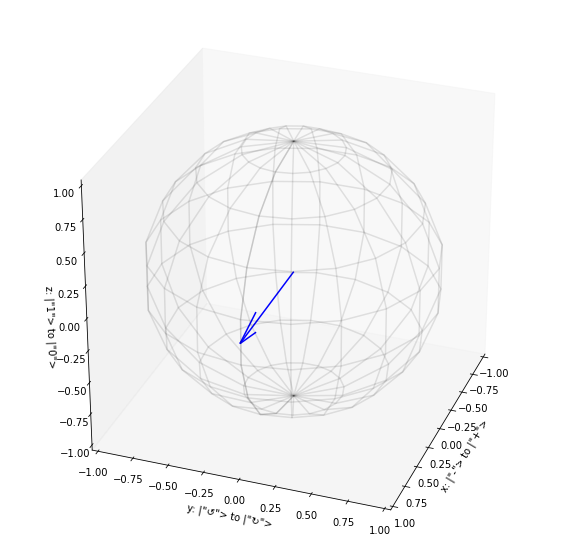

In [ ]:
plot_bloch(H * zero_qubit)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


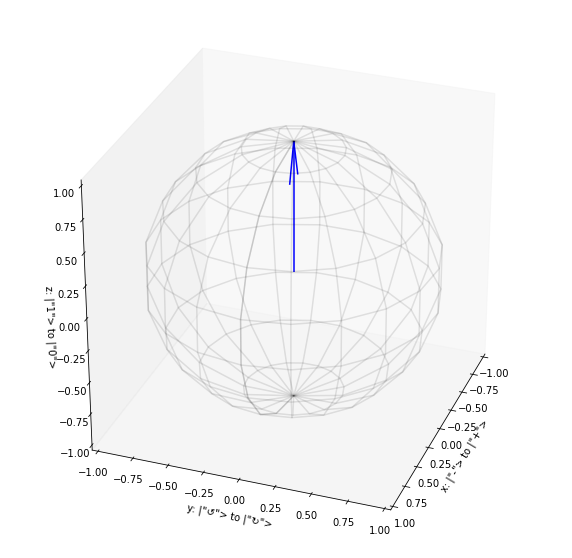

In [ ]:
plot_bloch(H * H * zero_qubit)

### Two-qubit gates

The gate for a two qubit state is a 4x4 matrix. The most important two qubit gate is the CNOT, or _Controlled Not_ gate. This gate applies a not to the second qubit in the pair, but only if the first qubit is in the $|1\rangle$ state. The CNOT gate looks like:

$$
\begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1 \\
0 & 0 & 1 & 0 \\
\end{pmatrix}
$$

Presented like this, the matrix doesn't make much sense, but if we look at how the two-qubit state vector is written, we see

$$
|00\rangle = 
\begin{pmatrix}
1 \\
0 \\
0 \\
0 \\
\end{pmatrix}, 
|01\rangle = 
\begin{pmatrix}
0 \\
1 \\
0 \\
0 \\
\end{pmatrix}, 
|10\rangle = 
\begin{pmatrix}
0 \\
0 \\
1 \\
0 \\
\end{pmatrix},
|11\rangle = 
\begin{pmatrix}
0 \\
0 \\
0 \\
1 \\
\end{pmatrix},
$$

If you stare at that long enough and think back to the rules we presented for matrix multiplication, you should be able to convince yourself that the CNOT only changes the state of vectors where the first qubit is in state $|1\rangle$ and its action is to flip the state of the second qubit.

The CNOT gate is important because it lets us generate _entanglement_.

## Bell pairs and entanglement

Along with superposition, one of the most important defining features of quantum states is _entanglement_. Entanglement occurs when we produce multi-qubit states that cannot be decomposed into a simple product of single-qubit states. Again, this is best explained with an example.

Many multi-qubit quantum states may be written as the decomposition of single qubit states. For example, $|00\rangle$:

$$
\begin{pmatrix} 1 \\ 0 \\ 0 \\ 0 \end{pmatrix} = |00\rangle = |0\rangle \otimes |0\rangle
$$

This is just a fancy way of saying the state $|00\rangle$ is made up of two individual qubits in the $|0\rangle$ state sitting next to each other. (Recall - a single qubit has two states, but two qubits has two _squared_, or four different states, so the output product here must have a different dimension.)

All classical states may be written as decompositions in this way, but there are quantum states that cannot be decomposed. We call these states _entangled_. For example, the state 

$$
\frac{1}{\sqrt{2}} \left( |00\rangle + |11\rangle \right) =
\frac{1}{\sqrt{2}} \left(
    \begin{pmatrix} 1 \\ 0 \\ 0 \\ 0 \end{pmatrix} + 
    \begin{pmatrix} 0 \\ 0 \\ 0 \\ 1 \end{pmatrix}
    \right) = 
\frac{1}{\sqrt{2}} \begin{pmatrix} 1 \\ 0 \\ 0 \\ 1 \end{pmatrix}
$$

cannot be broken down into a tensor product of single qubit states. We happen to call two qubits in this particular state a "Bell pair". (There are actually four different Bell pairs and they form a _basis_.)

**Exercise:** Try to find a tensor product of two single qubit states that produces a Bell pair. You won't find one! See if you can prove it isn't possible to produce the state that way.

## QASM - Quantum Assembly Language

Okay, at long last we can start writing some quantum _programs_.

<img src="https://media.giphy.com/media/CkqpoOOS0BCQU/giphy.gif">

Let's consider a diagram for the simple circuit - Hadamard on a single qubit, followed by measurement:

<img src="https://www.dropbox.com/s/196y0g4j88cnrrd/HandMeasure.png?dl=1" alt="Hadamard and measure circuit" height="350">

How do we write a quantum program to run this circuit?

[QASM](https://en.wikipedia.org/wiki/OpenQASM) is a "low-level" way of writing quantum programs. Because it is low-level, it lacks many of the abstractions that make writing very large programs convenient. But, on the other hand, because it is low level it is simple to see what is going on in short, simple programs without requiring us to learn a new library or high-level programming language. You can read much more about QASM in this [acadmic paper](https://arxiv.org/abs/1707.03429) from IBM.

In [ ]:
#@title "Python function to read and run QASM strings [Run me!]" { display-mode: "form" }
def run_qasm_string(qasm_str, verbose=True, shots=1024):
    qc = QuantumCircuit.from_qasm_str(qasm_str=qasm_str)
    backend = Aer.get_backend("qasm_simulator")
    job = execute(qc, backend, shots=shots)
    result = job.result()
    if verbose:
        print(result.get_counts())
    return result

To create a quantum program in QASM, we will write a special Python string that can cover multiple lines. We will do this like so:

```
quantum_program_string_name = """
--- code goes here ---
"""
```

This construct - putting a string between pairs of triple quotes - makes it possible to write a nice, reasy to read multi-line string.

For the program itself, first we need some "boilerplate" in our string:

```
OPENQASM 2.0;
include "qelib1.inc";
```

We just have to put there every time. Don't worry too much about it.

Next, we create a quantum register - `qreg` - this is the part of the program that "allocates" a qubit. We also create a classical register - `creg` - this is the part of the program that stores the value of our _measurement_ of the qubit.

Then, we apply the Hadamard gate to our qubit: `h q[0]`. Note that we are addressing the first element of the array of qubits in our register (which had length 1) by using the `0` in the brackets. Basically, the `[]`'s let us store many values under one variable _and_ give us a way to "look up" values inside that array. Finally, we'll measure the outcome.

In [ ]:
random_bit_qasm_str = """
OPENQASM 2.0;
include "qelib1.inc";

qreg q[1];
creg c[1];
h q[0];
measure q[0] -> c[0];
"""

In [ ]:
_ = run_qasm_string(random_bit_qasm_str)

{'0': 522, '1': 502}


We created an even _superposition_ of the `|0>` and `|1>` states with the `H` gate. However, we are measuring in the computational basis, so we can only measure either `|0>` or `|1>` as an outcome. What we find is a _probabilisitc_ result. About half the time we measure `|0>` and about half the time we measure `|1>`. The more times we repeat the experiment, the closer the fraction will be to 50/50. We're using the default 1,024 "shots" or experiment repetitions throghout this notebook (and we use 1,024 instead of 1,000 because we're computing geeks and like powers of two ^_^).

Let's look at one more - let's create the Bell pair we showed earlier:

<img src="https://www.dropbox.com/s/s31nu2w0psdgqxc/epr-circuit.png?dl=1" height="350">

In [ ]:
bell_qasm_str = """
OPENQASM 2.0;
include "qelib1.inc";

qreg q[2];
creg c[2];
h q[0];
cx q[0],q[1];
measure q[0] -> c[0];
measure q[1] -> c[1];
"""

In [ ]:
_ = run_qasm_string(bell_qasm_str)

{'00': 495, '11': 529}


## IBM Quantum Experience

Writing QASM is a fine way to run simple programs, but it can be a tricky way to get an intuition for what gates do and how the wavefunction evolves through a circuit, etc.

Let's look at another tool from IBM - [The IBM Quantum Experience](https://quantum-computing.ibm.com). In order to use the Quantum Experience, you need to create an IBMId. This is a free account that only requires an email address. With this account, you will have access to a cloud platform that provides Jupyter notebooks for learning Qiskit (IBM's Python library for writing complex quantum circuits) and a "Circuit Composer" that provides a visual GUI for building a circuit that reminds me a bit of writing music. You can simulate the circuit and inspect the wavefunction at each step. You can even run programs on a real quantum computer (although you may have to wait a while for the "jobs" in line ahead of you to run).

<img src="https://www.dropbox.com/s/fg4ukux99emz0e4/IBM-Quantum-Experience-Example.png?dl=1">

**Note** - the "Q-sphere" they are showing here is not the same thing as a Bloch sphere! You can read about it [here](https://quantum-computing.ibm.com/docs/iqx/visualizations#q-sphere-view). We aren't going to discuss it now, but it is a way of visualizing the state of more than one qubit (the Bloch sphere works for one and only one qubit).

The circuit composer does several very nice things for us. It provides a set of [visualization tools](https://quantum-computing.ibm.com/docs/iqx/visualizations) to help us understand the evolution of a (small) number of qubits. It lets us write circuits using QASM and the circuit display will reflect that code. It also lets us build a circuit graphically and then provides the QASM for that circuit.

We can even run the circuit on a real quantum computer! Here are the results from running on one of IBM's 5 qubit machines ("Athens"):

<img src="https://www.dropbox.com/s/rva9tk61cl4hfmd/Bell-on-hardware.png?dl=1">

Note that the result is not _exactly_ what we predicted. There is a small chance of a $|01\rangle$ or $|10\rangle$ state. This is due to _noise_ on the quantum computer. Noise is a complex topic and we won't get into it in depth. The simple way to think about it is that it is very hard to isolate the computer from the environment, and very hard to make our gate operations perfect (they're microwave pulses shining on little bits of metal, after all). Dealing with noise (mitigation, correction, device improvements, etc.) is one of the dominant activities in quantum computing research. Things aren't perfect yet, but we've come a long way, with progress really accelerating over the last decade.

## A practical quantum application

Based on "Quantum Spy Hunter" from the book [Programming Quantum Computers](https://www.oreilly.com/library/view/programming-quantum-computers/9781492039679/) by O'Reilly.

Suppose Alice and Bob share a pair of communication channels. One can transmit classical bits and one can transmit qubits. Practically this is accomplished using an algorithm called [quantum teleportation](https://en.wikipedia.org/wiki/Quantum_teleportation).

<img src="https://media.giphy.com/media/l3vRnfUVg1ihOl0I0/giphy.gif">

By the way, quantum teleportation is not science fiction, it is a real thing [we do at Fermilab!](https://news.fnal.gov/2020/12/fermilab-and-partners-achieve-sustained-high-fidelity-quantum-teleportation/) Sadly though we can't use it to beam ourselves anywehere...

Alice would like to send Bob some quantum information, but she fears there may be eavesdroppers on the channel. Therefore, they have agreed on an exchange protocol. Before sending sensitive data, they will send some "spy sniffer" qubits and some classical bits. The classical bits will follow an agreed upon code for a set of operations to perform on the qubits. These operations will establish whether the qubit was tampered with. Note that Alice and Bob had to agree on how to interpret these classical bits in advance, but afterwards, all of their information exchange is fully "public" (takes place on these channels).

<img src="https://www.dropbox.com/s/pho61h8vb8tzvvd/nospyhunter.png?dl=1">


In [ ]:
pp = pprint.PrettyPrinter(indent=4)

In [ ]:
no_spy_hunter_string = """
OPENQASM 2.0;
include "qelib1.inc";

// set up quantum registers - Alice, Bob, and the fiber
qreg alice[1];
qreg fiber[1];
qreg bob[1];

// set up classical registers
creg ahad[1];
creg aval[1];
creg fval[1];
creg bval[1];

// generate two random bits with Alice's QPU
reset alice[0];
h alice[0];
measure alice[0] -> ahad[0];
reset alice[0];
h alice[0];
measure alice[0] -> aval[0];

// prepare Alice's qubit - randomly create one of
// |0>, |1>, |+>, or |->, but don't say which...
reset alice[0];
if(aval==1) x alice[0];
if(ahad==1) h alice[0];

// send the qubit
swap alice[0],fiber[0];
// receive the qubit
swap fiber[0],bob[0];

// Alice sends ahad and aval to Bob.
// read the transmitted qubit
if(ahad==1) h bob[0];
if(aval==1) x bob[0];

measure bob[0] -> bval[0];
"""

In [ ]:
result = run_qasm_string(no_spy_hunter_string, verbose=False)
pp.pprint(result.get_counts())
# read: 'bval fval aval ahad'

{'0 0 0 0': 244, '0 0 0 1': 274, '0 0 1 0': 262, '0 0 1 1': 244}


Interpretation: we always find '0' in Bob's measurement value. This means he always knew the exactly correct sequence of gates to apply to de-scramble the qubit back to `|0>`. So, the qubit was never tampered with.

By the way - this is what this circuit looks like in the Circuit Composer:

<img src="https://www.dropbox.com/s/ngddrjck4t6v1au/No-Spy-Hunter.png?dl=1">

Note - the QASM code has the comments taken out. Also, the spacing is a bit fiddly, but if you do it right, when you run the Inspector, it will step through the QASM code line-by-line in sync with the graphic circuit.

We can run the code on the Quantum Experience website (here, looking at a simulator) and view the output:

<img src="https://www.dropbox.com/s/g2hx7pvdn36vfl4/No-Spy-Hunter-Job.png?dl=1">

It's what we expected.

Now, let's introduce a spy (traditionally named "Eve") and see what happens.

<img src="https://www.dropbox.com/s/6w29exyjhhp947t/nospyhunter-eve.png?dl=1">

Eve is able to capture data in flight and she has a fully functioning quantum lab, so she can create and measure qubits and send any information she would like on the channel. Eve's goal is to capture and store sensitive quantum information.

In [ ]:
spy_hunter_string = """
OPENQASM 2.0;
include "qelib1.inc";

// set up quantum registers - Alice, Bob, and the fiber
qreg alice[1];
qreg fiber[1];
qreg bob[1];

// set up classical registers
creg ahad[1];
creg aval[1];
creg fval[1];
creg bval[1];

// generate two random bits with Alice's QPU
reset alice[0];
h alice[0];
measure alice[0] -> ahad[0];
reset alice[0];
h alice[0];
measure alice[0] -> aval[0];

// prepare Alice's qubit - randomly create one of
// |0>, |1>, |+>, or |->, but don't say which...
reset alice[0];
if(aval==1) x alice[0];
if(ahad==1) h alice[0];

// send the qubit
swap alice[0],fiber[0];

// now a spy intercepts - can't see true quantum state,
// can only measure and try to replace the state.
barrier alice[0],fiber[0],bob[0];
measure fiber[0] -> fval[0];
reset fiber[0];
if(fval==1) x fiber[0];
barrier alice[0],fiber[0],bob[0];

// receive the qubit
swap fiber[0],bob[0];

// Alice sends ahad and aval to Bob. He
// inverts Alice's transformations and
// reads the transmitted qubit
if(ahad==1) h bob[0];
if(aval==1) x bob[0];

measure bob[0] -> bval[0];
"""

In [ ]:
result = run_qasm_string(spy_hunter_string, verbose=False)
pp.pprint(result.get_counts())
# read: 'bval fval aval ahad'

{   '0 0 0 0': 243,
    '0 0 0 1': 74,
    '0 0 1 1': 58,
    '0 1 0 1': 70,
    '0 1 1 0': 232,
    '0 1 1 1': 64,
    '1 0 0 1': 62,
    '1 0 1 1': 74,
    '1 1 0 1': 77,
    '1 1 1 1': 70}


**Note** - if you try to run this program on quantum hardware, it will complain because we are conditioning based on some measurement outcomes. You'd need to break the code up to really run it on IBM's service.

The interpretation is subtle and requires walking through case-by-case. Remember Alice and Bob have agreed in advance to exchange classical bits that tell Bob which quantum gates to apply to the spy-sniffer qubit Alice has sent. Bob should get the `|0>` state if he has applied the correct gates to an undisturbed qubit. If Bob ever finds a `|1>`, he knows the qubit has been tampered with and someone is listening in on their communications.

<img src="https://media.giphy.com/media/w2Pihe5XPiK3e/giphy.gif">

Note that because quantum mechanics is _probabilistic_ there is no guarantee every spy-sniffer qubit will reveal eavesdropping!

* `0 0 0 0` - Alice doesn't apply an H or an X, sends `|0>`. Eve measures a 0, so she sends `|0>`. Bob gets '00' from Alice and doesn't apply any gates to `|0>` and measures a '0'. **Spy not caught.**
* `0 0 0 1` - Alice applies a Hadamard and sends `|+>`. Eve measures a 0 so she sends `|0>`. Bob gets '01' from Alice, so he applies a Hadamard to `|0>` and produces `|->`, but then measures a '0' (50/50 chance). **Spy not caught.**
* `0 0 1 1` - Alice applies X and H, and sends `|->`. Eve measures 0 and sends `|0>`. Bob gets '11' from Alice, so he applies a H and then an X and produces `|+>`, but then measures a '0' (50/50 chance). **Spy not caught.**
* `0 1 0 1` - Alice applies an H and sends `|+>`. Eve measures a '1', so she sends '|1>'. Bob gets '01' from Alice, so he applies an H and produces `|->`, but then measures a '0' (50/50 chance). **Spy not caught.**
* `0 1 1 0` - Alice applies and X and sends `|1>`. Eve measures `|1>` and sends `|1>`. Bob gets `10` from Alice, so applies an X to `|1>` and gets `|0>`. **Spy not caught.**
* `0 1 1 1` - Alices applies X and H and send `|->`.  Eve measures 1 and sends `|1>`. Bob gets '11' from Alice so he applies a H and then an X and produces `-|->`. He then measures a '0' (50/50 chance). **Spy not caught.**
* `1 0 0 1` - Alice applies an H and sends `|+>`. Eve measures 0 and so sends `|0>`. Bob gets '01' from Alice so he applies an H to produce `|+>` and measures a '1' (50/50 chance). **Spy is caught!**
* `1 0 1 1` - Alice applies X and H, and sends `|->`. Eve measures 0 and sends `|0>`. Bob gets '11' from Alice, so he applies a H and then an X and produces `|+>`, and then measures a '1' (50/50 chance). **Spy is caught!**
* `1 1 0 1` - Alice applies an H and sends `|+>`. Eve measures a '1', so she sends '|1>'. Bob gets '01' from Alice, so he applies an H and produces `|->`, and then measures a '1' (50/50 chance). **Spy is caught!**
* `1 1 1 1` - Alices applies X and H and send `|->`.  Eve measures 1 and sends `|1>`. Bob gets '11' from Alice so he applies a H and then an X and produces `-|->`. He then measures a '1' (50/50 chance). **Spy is caught!**

So, what was the chance of catching the spy with any given sniffer qubit? We can use some Python to query the _dictionary_ the IBM simulator returned to us:

In [ ]:
times_caught = 0
for i in result.get_counts().items():
    if i[0][0] == '1':
        times_caught += i[1]
print('The spy was caught {} times,'.format(times_caught))
prob_of_catching = times_caught / 1024.0
print('---> = {}% of the times we sent a spy-hunter qubit.'.format(prob_of_catching * 100))

The spy was caught 283 times,
---> = 27.63671875% of the times we sent a spy-hunter qubit.


So, if the spy has a roughly 25% chance of being caught with each spy-hunter qubit, how many spy-hunter qubits do Alice and Bob need to exchange? Theoretically, an infinite number, but suppose they were okay with a 99.999% chance of catching a spy. How many do they need to send?

It is easiest to solve this sort of probability problem not as what is the chance of 'one catch' plus 'two catches', etc., but rather as 100% minus the probability of 'no catches'. Imagine you sent one qubit, you have roughly 75% chance of missing the spy. If you send two, you have a 75% times 75% equals 56% chance of missing the spy, so a 44% chance of catching the spy. Every qubit you send reduces the chances of missing the spy, with the chance of the spy slipping through dropping by 3/4 with each qubit.

In [ ]:
threshold = 0.99999

def F(x):
    return (1 - (1 - prob_of_catching)**x) - threshold

num_times = scipy.optimize.bisect(F, 1, 50); num_times

35.59181208717746

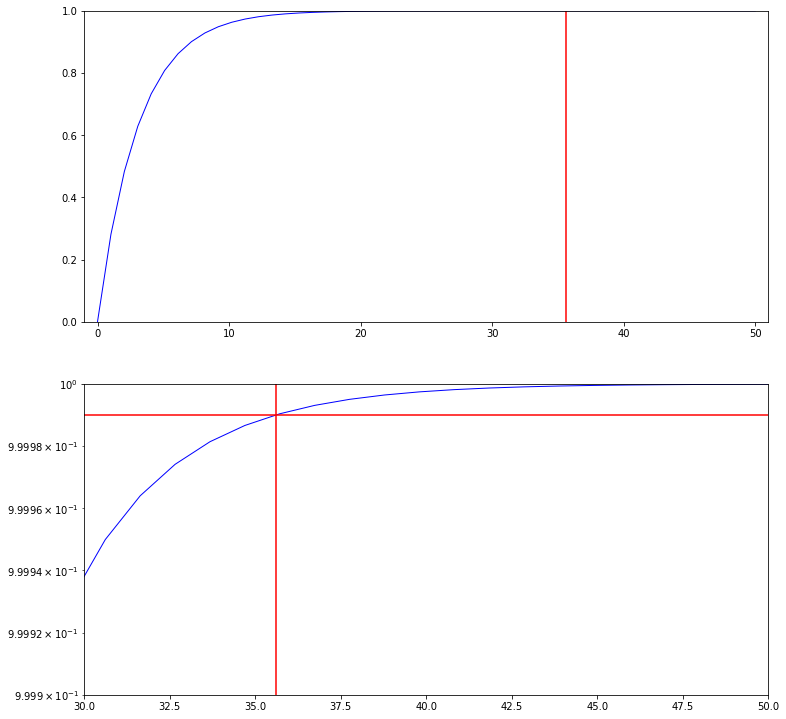

In [ ]:
x = np.linspace(0, 50)
y = 1 - (1 - prob_of_catching)**x
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(bottom=0.025, left=0.025, top=0.975, right=0.975)

ax1 = plt.subplot(2, 1, 1)
plot1, = plt.plot(x, y, color='blue', linewidth=1)
ax1.set_xlim([-1, 51])
ax1.set_ylim([0, 1])
ax1.axvline(x=num_times, color='red')

ax2 = plt.subplot(2, 1, 2)
plot2, = plt.plot(x, y, color='blue', linewidth=1)
ax2.set_xlim([30, 50])
ax2.set_ylim([0.9999, 1])
ax2.set_yscale('log')
ax2.axhline(y=threshold, color='red')
ax2.axvline(x=num_times, color='red')

If you have a quantum communication channel this is a pretty cheap check to see if there are eavesdroppers. 40 times (2 classical bits plus 1 qubit). Note we don't even care if the classical channel is observed. Because Eve doesn't know what '00', '01', etc. _mean_, there is nothing she can do with that information.

Also note - Eve has no way to predict the classical _sequence_ of 'xy' bits. Resolving the qubit is a truly random process. Most "random" computational processes are not actually random - they are pseudorandom and use generators that have patterns built in. Those patterns may be quite long, but they're there, and if Eve observed long enough, she could find a pattern. There is absolutely no pattern to the classical bits Alice is sending!